In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
#connecting to spotify API using Spotipy
cid ="12b051049eb14a05ac3dd252770b6bd3" 
secret = "8844a8e5f63f4fa3998ba69811b2e005"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
artist_name = []
track_name = []
popularity = []
track_id = []

#loading in 1000 different tracks from 2020 with Spotipy
for i in range(0,1000,10):
    track_results = sp.search(q='year:2020', type='track', limit=10,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        #populating lists we will use for DF later
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

In [4]:
#storing data in dataframe
df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})

In [5]:
rows = []
batchsize = 100

# Create list of audio features for each song
for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t != None:
            rows.append(t)


In [6]:
# Storing audio feature data of each song in a dataframe
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of the dataset: (1000, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.653,0.524,11,-9.016,0,0.0502,0.1120,0.000000,0.2030,0.553,83.970,audio_features,6tDDoYIxWvMLTdKpjFkc1B,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,https://api.spotify.com/v1/tracks/6tDDoYIxWvML...,https://api.spotify.com/v1/audio-analysis/6tDD...,160191,4
1,0.699,0.558,9,-14.713,1,0.0541,0.1650,0.883000,0.0932,0.398,99.996,audio_features,6s0QJ4tfTOkkkOMQz8HCrg,spotify:track:6s0QJ4tfTOkkkOMQz8HCrg,https://api.spotify.com/v1/tracks/6s0QJ4tfTOkk...,https://api.spotify.com/v1/audio-analysis/6s0Q...,83853,4
2,0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,0.5430,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
3,0.642,0.749,6,-7.060,0,0.2890,0.0299,0.000000,0.2540,0.561,81.862,audio_features,2spPLfhb8c7rPxz28IdeXR,spotify:track:2spPLfhb8c7rPxz28IdeXR,https://api.spotify.com/v1/tracks/2spPLfhb8c7r...,https://api.spotify.com/v1/audio-analysis/2spP...,34750,1
4,0.436,0.655,1,-8.370,0,0.0583,0.4990,0.000008,0.6880,0.412,121.002,audio_features,3YJJjQPAbDT7mGpX3WtQ9A,spotify:track:3YJJjQPAbDT7mGpX3WtQ9A,https://api.spotify.com/v1/tracks/3YJJjQPAbDT7...,https://api.spotify.com/v1/audio-analysis/3YJJ...,279204,4


In [7]:
# EM algo with 2 dimensions
# Needs to be modified to fit more features (~7) in the future

def EM(dat, k):
    
    p_class=np.zeros(k)
    means=np.zeros((k,2))
    covars=np.zeros((k,2,2))
    mean_dist=np.array(0)
    p_data_given_class=np.zeros((len(dat),k))
    #initializations
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    for dim in range(k):
        covars[dim,:,:]=np.cov(np.transpose(dat))
        means[dim,:]=dat.iloc[init_idx[dim]]
        p_class[dim]=1/k
    
    for step in range(50):  
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        for dim in range(k):
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim,:], cov=covars[dim,:,:])])
        p_class_given_data=p_data_given_class*p_class

        sums=np.sum(p_class_given_data, axis=1)
        for dim in range(k):
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
        n_class = np.sum(p_class_given_data, axis=0)
        p_class=n_class/len(dat)

        # mean and covar updates
        for dim in range(k):
            means[dim,0]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,0])*(1/n_class[dim])
            means[dim,1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,1])*(1/n_class[dim])
            covars[dim,0,0]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,0]-means[dim,0])**2))*(1/n_class[dim])
            covars[dim,1,1]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,1]-means[dim,1])**2))*(1/n_class[dim])                                                      
            covars[dim,0,1]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
            covars[dim,1,0]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
    mean_dist=0
    
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
    mean_dist=mean_dist/(len(dat)*k)
    return p_class, means, covars, mean_dist, p_class_given_data

In [8]:
# Method to compute the probabilty a new song belongs to each genre (cluster)
def p_class_given_data(song, k, means, covars, p_class):
    p_song_given_cluster = []
    p_cluster_given_song = []
    for cluster in range(k):
        p_song_given_cluster.append( stats.multivariate_normal.pdf(x=song, mean=means[cluster], cov=covars[cluster]))
        p_cluster_given_song.append( p_song_given_cluster[cluster] * p_class[cluster] )
    
    summ = sum(p_cluster_given_song)
    
    for cluster in range(k):
        p_cluster_given_song[cluster] = p_cluster_given_song[cluster] / summ
    
    return  p_cluster_given_song

In [9]:
# Preliminary model using only 2 features
test_df = df_audio_features[['acousticness', 'energy']]
test_df
p2, m2, c2,d2, pc2 = EM(test_df,2)

clusters = []
for pt in pc2:
    if(pt[0]>pt[1]):
        clusters.append(0)
    else:
        clusters.append(1)

In [10]:
test_song =  [0.000112,   0.506]
probs = p_class_given_data(test_song, 2,m2, c2, p2)
print("Probability new song belongs to each cluster: ", probs)

Probability new song belongs to each cluster:  [0.6534666004710983, 0.3465333995289018]


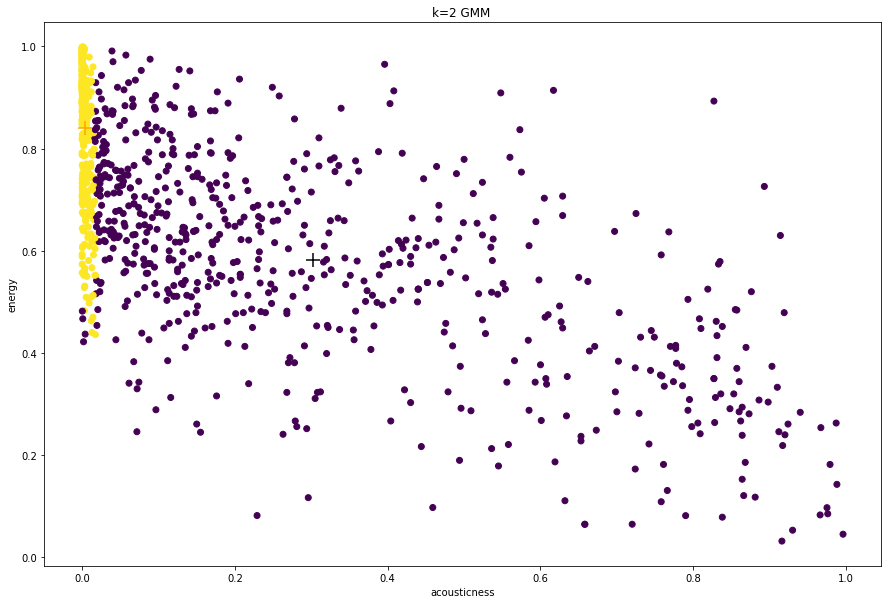

In [11]:
# Preliminary GMM model using only 2 features
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('k=2 GMM ')
ax.scatter(test_df['acousticness'],test_df['energy'], c=clusters)
ax.scatter(m2[0][0], m2[0][1],  c='black', marker='+', s = 200)
ax.scatter(m2[1][0], m2[1][1],  c='orange', marker='+', s= 200)
ax.set_xlabel('acousticness')
ax.set_ylabel('energy');

## Project Check In



***

Our data so far is two dataframes contaning song data from popular songs in 2020 from the Spotify API. df_tracks has the basic song data including the artist name, song name, track id and a popularity rating. df_audio_featurs contains the audio features for each song in the df_tracks data frame. This includes acousticness, danceability, energy, etc. 

We have a preliminary GMM with k=2 using acousticness and energy as our features. The crosses on the plot represent the mean of each cluster. With this preliminary data, we have a proof of concept of being able to run the EM algorithm on our data set. We are also able to take a new song, and predict the probability it belongs to each cluster. For example a song with 0.000012 acousticness and 0.503 energy has a 95% chance of belonging to "cluster 2" with out preliminary data GMM. 

The remaining work we have is to modify the EM method above to acccount for all 9 audio features instead of just two. Additionally, we need to extract audio features of each song using Aubio, and run the EM algorithm on that data as well as the spotify data. Finally, we need to analyze and compare the Spotify API GMM and the Aubio GMM to see how closley we mimiced Spotifys song classifictaion. 